In [1]:
from typing import Optional
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from learning_machines_drift import FileBackend, Monitor, Registry
from sdmetrics.timeseries import TimeSeriesDetectionMetric


In [2]:
def get_synthetic_time_series(df: pd.DataFrame, n_samples: int=200, translate_mean: int=0, translate_scale: float=5, noise_scale:float=10, seed:Optional[int]=None) -> np.ndarray:
    """Generate synthetic temporal samples from single heart rate series"""
    np.random.seed(seed)
    # Get as numpy
    heart_rate =df.to_numpy()
    # Translate x-axis by cycle
    new_samples = heart_rate.take((np.arange(0, df.shape[0])[np.newaxis, ...] + np.random.randint(0, df.shape[0], size=n_samples)[..., np.newaxis]), mode='wrap')
    # Translate y-axis by noose
    new_samples += np.random.normal(np.random.normal(loc=translate_mean, scale=translate_scale, size=[n_samples]))[:, np.newaxis]
    # Add noise everywhere
    new_samples += np.random.normal(np.random.normal(loc=0, scale=noise_scale, size=[n_samples, heart_rate.shape[0]]))
    return new_samples

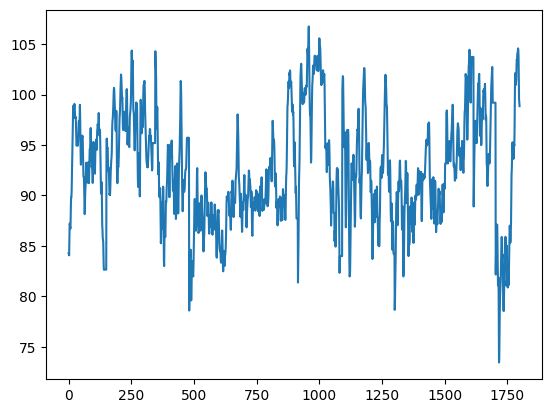

In [3]:
# Plot raw data from single patient
df = pd.read_csv("temporal_data/mit_bih_hr1.txt", header=None)
plt.plot(df.to_numpy())

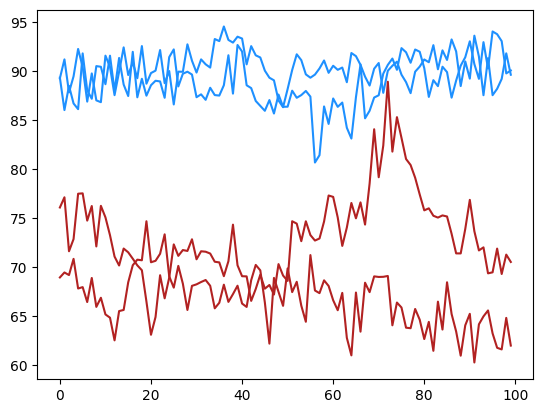

In [4]:
# Generate some data and plot first four examples
SEED1, SEED2 = 0, 2
c1, c2 = "dodgerblue", "firebrick"
new_samples_1 = get_synthetic_time_series(df, n_samples=100, translate_mean=0, translate_scale=0, noise_scale=1, seed=SEED1)
new_samples_2 = get_synthetic_time_series(df, n_samples=100, translate_mean=-20, translate_scale=0, noise_scale=1, seed=SEED2)
plt.plot(new_samples_1.T[:100, :2], color=c1)
plt.plot(new_samples_2.T[:100, :2], color=c2)
plt.show()

## Exploring esig

In [5]:

# Example from: https://github.com/datasig-ac-uk/esig
import esig

stream = np.array([
    [1.0, 1.0],
    [3.0, 4.0],
    [5.0, 2.0],
    [8.0, 6.0]
])
depth = 1

sig = esig.stream2logsig(stream, depth) # compute the signature
print(sig)

[7. 5.]


In [6]:
# List of new_samples
new_samples = np.concatenate([new_samples_1, new_samples_2], axis=0)

# New sig features for new_samples
sig_feature = np.array([esig.stream2logsig(sample[:100, np.newaxis], depth)[0] for sample in new_samples])


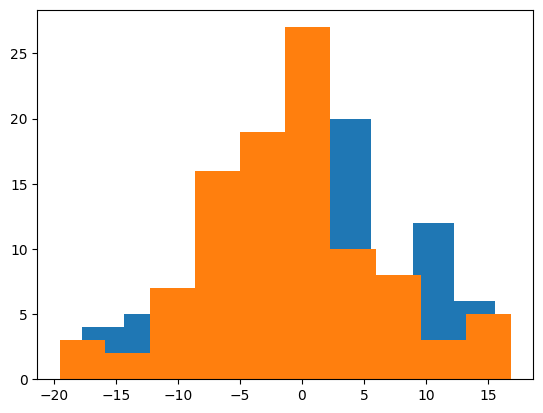

In [7]:
# Plot on hist
plt.hist(sig_feature[:100])
plt.hist(sig_feature[100:])
plt.show()

In [8]:
from sklearn.metrics.pairwise import euclidean_distances
dists = euclidean_distances(sig_feature[..., np.newaxis])


In [9]:
max_idx = np.unravel_index(np.argmax(dists, axis=None), dists.shape)
min_idx = np.unravel_index(np.argmin(dists + np.eye(dists.shape[0]), axis=None), dists.shape)
print(max_idx, min_idx)
print(dists[max_idx], dists[min_idx])


(103, 196) (128, 141)
36.31474285658611 0.001008533812393172


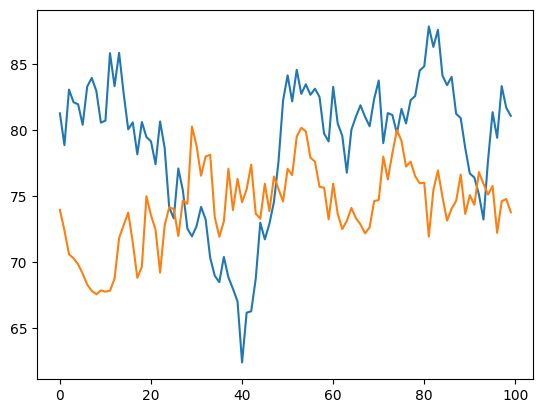

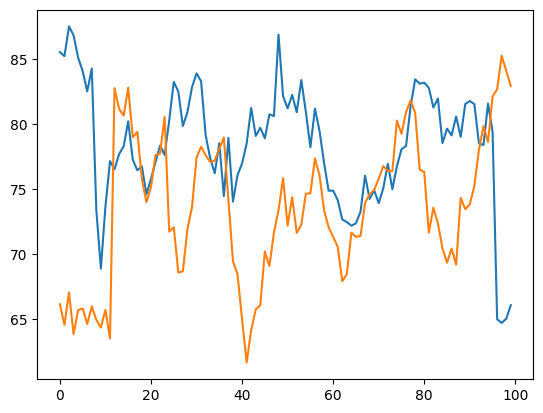

In [10]:

# Plot signatures of similar and different time series
lim = 100
plt.plot(new_samples[min_idx[0], :lim])
plt.plot(new_samples[min_idx[1], :lim])
plt.show()
plt.plot(new_samples[max_idx[0], :lim])
plt.plot(new_samples[max_idx[1], :lim])
plt.show()

## Exploring LSTM detection with SDMetrics

In [11]:
# Make df for detect
df_for_detect = pd.DataFrame(np.array([
    np.repeat(np.arange(0, new_samples.shape[0]), new_samples.shape[1]),
    np.tile(np.arange(0, new_samples.shape[1]), new_samples.shape[0]),
    new_samples.reshape(-1),
    np.append(np.zeros(new_samples.reshape(-1).shape[0]//2), np.ones(new_samples.reshape(-1).shape[0]//2))]).T,
    columns=["patient_id", "time", "hr", "label"]
)
# df_for_detect.drop(columns=["patient_id"], inplace=True)

In [ ]:
# Set-up LSTM detection
from sdmetrics.timeseries import LSTMDetection
lstm_detect = LSTMDetection()
lstm_detect.compute(
    synthetic_data=df_for_detect[df_for_detect["label"]==0],
    real_data=df_for_detect[df_for_detect["label"]==1],
    metadata={
        "sequence_index": "time",
        "entity_columns": ["patient_id", "time"],
        "fields": {
            "hr": {"type": "float"},
            "time": {"type": "float"},
            "patient_id": {"type": "int"},
            "label": {"type": "int"},
        }
    }
)